# __S2FFT CUDA Implementation__
---

[![colab image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/astro-informatics/s2fft/blob/main/notebooks/JAX_HEALPix_frontend.ipynb)

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

# Install s2fft and data if running on google colab.
if IN_COLAB:
    !pip install s2fft &> /dev/null

Short comparaison between the pure JAX implementation and the CUDA implementation of the S2FFT algorithm.

In [2]:
import jax
from jax import numpy as jnp
import argparse
import time
from time import perf_counter
import matplotlib.pyplot as plt
import seaborn as sns

jax.config.update("jax_enable_x64", True)

from s2fft.utils.healpix_ffts import  healpix_fft_jax, healpix_ifft_jax, healpix_fft_cuda, healpix_ifft_cuda

import numpy as np
import s2fft 
from s2fft import forward , inverse
import jax_healpy as jhp


from jax._src.numpy.util import promote_dtypes_complex


In [3]:
sampling = "healpix"

def mse(x, y):
    return jnp.mean(jnp.abs(x - y)**2)


def run_fwd_test(nside):
    L = 2 * nside 

    total_pixels = 12 * nside**2
    arr = jax.random.normal(jax.random.PRNGKey(0), (total_pixels, ))

    method = "cuda"
    start = time.perf_counter()
    cuda_res = forward(arr, L, nside=nside,sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    cuda_jit_time = end - start

    start = time.perf_counter()
    cuda_res = forward(arr, L, nside=nside,sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    cuda_run_time = end - start

    method = "jax"
    start = time.perf_counter()
    jax_res = forward(arr, L, nside=nside,sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    jax_jit_time = end - start

    start = time.perf_counter()
    jax_res = forward(arr, L, nside=nside,sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    jax_run_time = end - start

    method = "jax_healpy"
    arr += 0j
    arr = jax.device_put(arr, jax.devices("cpu")[0])
    start = time.perf_counter()
    flm = s2fft.forward(arr, L, nside=nside, sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    healpy_jit_time = end - start

    start = time.perf_counter()
    flm = s2fft.forward(arr, L, nside=nside, sampling=sampling, method=method).block_until_ready()
    end = perf_counter()
    healpy_run_time = end - start

    print(f"For nside {nside}")
    print(f" -> FWD")
    print(f" -> -> cuda_jit_time: {cuda_jit_time:.4f}, cuda_run_time: {cuda_run_time:.4f} mse against hp {mse(cuda_res, flm)}")
    print(f" -> -> jax_jit_time: {jax_jit_time:.4f}, jax_run_time: {jax_run_time:.4f} mse against hp {mse(cuda_res, flm)}")
    print(f" -> -> healpy_jit_time: {healpy_jit_time:.4f}, healpy_run_time: {healpy_run_time:.4f}")

    return cuda_jit_time , cuda_run_time, jax_jit_time, jax_run_time , healpy_jit_time, healpy_run_time


def run_bwd_test(nside):
    
    sampling = "healpix"
    L = 2 * nside
    total_pixels = 12 * nside**2
    arr = jax.random.normal(jax.random.PRNGKey(0), (total_pixels, )) + 0j
    alm = forward(arr, L, nside=nside, sampling=sampling, method="jax_healpy")
    
    method = "cuda"
    start = time.perf_counter()
    cuda_res = inverse(alm, L, nside=nside,sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    cuda_jit_time = end - start
    start = time.perf_counter()
    cuda_res = inverse(alm, L, nside=nside,sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    cuda_run_time = end - start

    method = "jax"
    start = time.perf_counter()
    cuda_res = inverse(alm, L, nside=nside,sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    jax_jit_time = end - start
    start = time.perf_counter()
    cuda_res = inverse(alm, L, nside=nside,sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    jax_run_time = end - start

    method = "jax_healpy"
    sampling = "healpix"

    alm = jax.device_put(alm, jax.devices("cpu")[0])
    start = time.perf_counter()
    f = inverse(alm, L, nside=nside, sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    healpy_jit_time = end - start

    start = time.perf_counter()
    f = inverse(alm, L, nside=nside, sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    healpy_run_time = end - start

    print(f"For nside {nside}")
    print(f" -> BWD")
    print(f" -> -> cuda_jit_time: {cuda_jit_time:.4f}, cuda_run_time: {cuda_run_time:.4f} mse against hp {mse(cuda_res, f)}")
    print(f" -> -> jax_jit_time: {jax_jit_time:.4f}, jax_run_time: {jax_run_time:.4f} mse against hp {mse(cuda_res, f)}")
    print(f" -> -> healpy_jit_time: {healpy_jit_time:.4f}, healpy_run_time: {healpy_run_time:.4f} ")

    return cuda_jit_time , cuda_run_time, jax_jit_time, jax_run_time , healpy_jit_time, healpy_run_time

In [4]:
jax.clear_caches()

In [5]:
fwd_times = []
bwd_times = []
nsides = [4 , 8, 16 , 32, 64, 128 , 256]
for nside in nsides:
    fwd_times.append(run_fwd_test(nside))
    bwd_times.append(run_bwd_test(nside))

For nside 4
 -> FWD
 -> -> cuda_jit_time: 0.8628, cuda_run_time: 0.0017 mse against hp 1.647630022437035e-05
 -> -> jax_jit_time: 0.8502, jax_run_time: 0.0011 mse against hp 1.647630022437035e-05
 -> -> healpy_jit_time: 0.4688, healpy_run_time: 0.0045
For nside 4
 -> BWD
 -> -> cuda_jit_time: 0.7953, cuda_run_time: 0.0016 mse against hp 8.382155199574185e-31
 -> -> jax_jit_time: 0.9567, jax_run_time: 0.0010 mse against hp 8.382155199574185e-31
 -> -> healpy_jit_time: 0.0173, healpy_run_time: 0.0003 
For nside 8
 -> FWD
 -> -> cuda_jit_time: 0.9469, cuda_run_time: 0.0043 mse against hp 6.652257621288162e-07
 -> -> jax_jit_time: 1.0494, jax_run_time: 0.0017 mse against hp 6.652257621288162e-07
 -> -> healpy_jit_time: 0.2135, healpy_run_time: 0.0096
For nside 8
 -> BWD
 -> -> cuda_jit_time: 0.9859, cuda_run_time: 0.0037 mse against hp 4.140425341734151e-30
 -> -> jax_jit_time: 1.2791, jax_run_time: 0.0021 mse against hp 4.140425341734151e-30
 -> -> healpy_jit_time: 0.0167, healpy_run_time

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.plotting_context("poster")
sns.set(font_scale=1.4)


def plot_times(title, nsides, chrono_times):

    # Extracting times from the chrono_times
    cuda_jit_times = [times[0] for times in chrono_times]
    cuda_run_times = [times[1] for times in chrono_times]
    jax_jit_times = [times[2] for times in chrono_times]
    jax_run_times = [times[3] for times in chrono_times]
    healpy_jit_times = [times[4] for times in chrono_times]
    healpy_run_times = [times[5] for times in chrono_times]

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    f2 = lambda a: np.log2(a)
    g2 = lambda b: b**2


    # Plot for JIT times
    ax1.plot(nsides, cuda_jit_times, 'g-o', label='ours')
    ax1.plot(nsides, jax_jit_times, 'b-o', label='s2fft base')
    ax1.plot(nsides, healpy_jit_times, 'r-o', label='Healpy')
    ax1.set_title('Compilation Times (first run)')
    ax1.set_xlabel('nside')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_xscale('function', functions=(f2, g2))
    ax1.set_xticks(nsides)
    ax1.set_xticklabels(nsides)
    ax1.legend()
    ax1.grid(True, which="both", ls="--")

    # Plot for Run times
    ax2.plot(nsides, cuda_run_times, 'g-o', label='ours')
    ax2.plot(nsides, jax_run_times, 'b-o', label='s2fft base')
    ax2.plot(nsides, healpy_run_times, 'r-o', label='Healpy')
    ax2.set_title('Execution Times')
    ax2.set_xlabel('nside')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xscale('function', functions=(f2, g2))
    ax2.set_xticks(nsides)
    ax2.set_xticklabels(nsides)
    ax2.legend()
    ax2.grid(True, which="both", ls="--")

    # Set the overall title for the figure
    fig.suptitle(title, fontsize=16)

    # Show the plots
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make space for the suptitle
    plt.show()

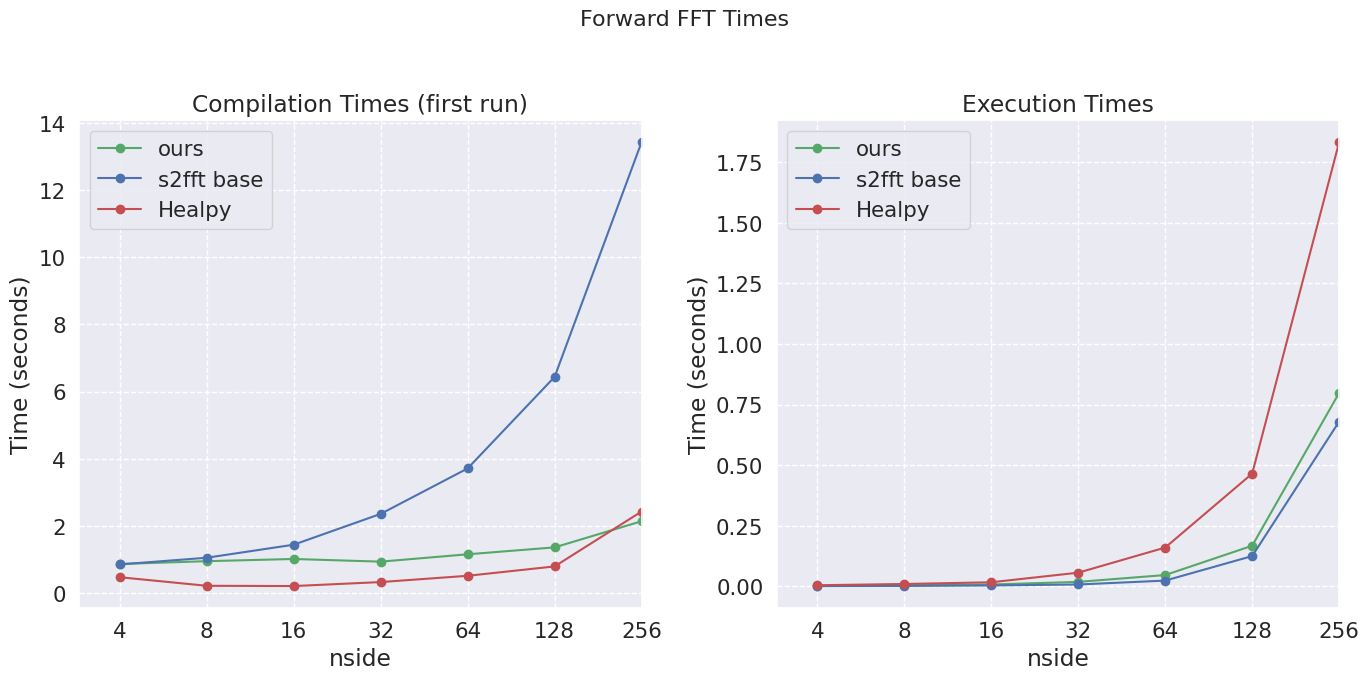

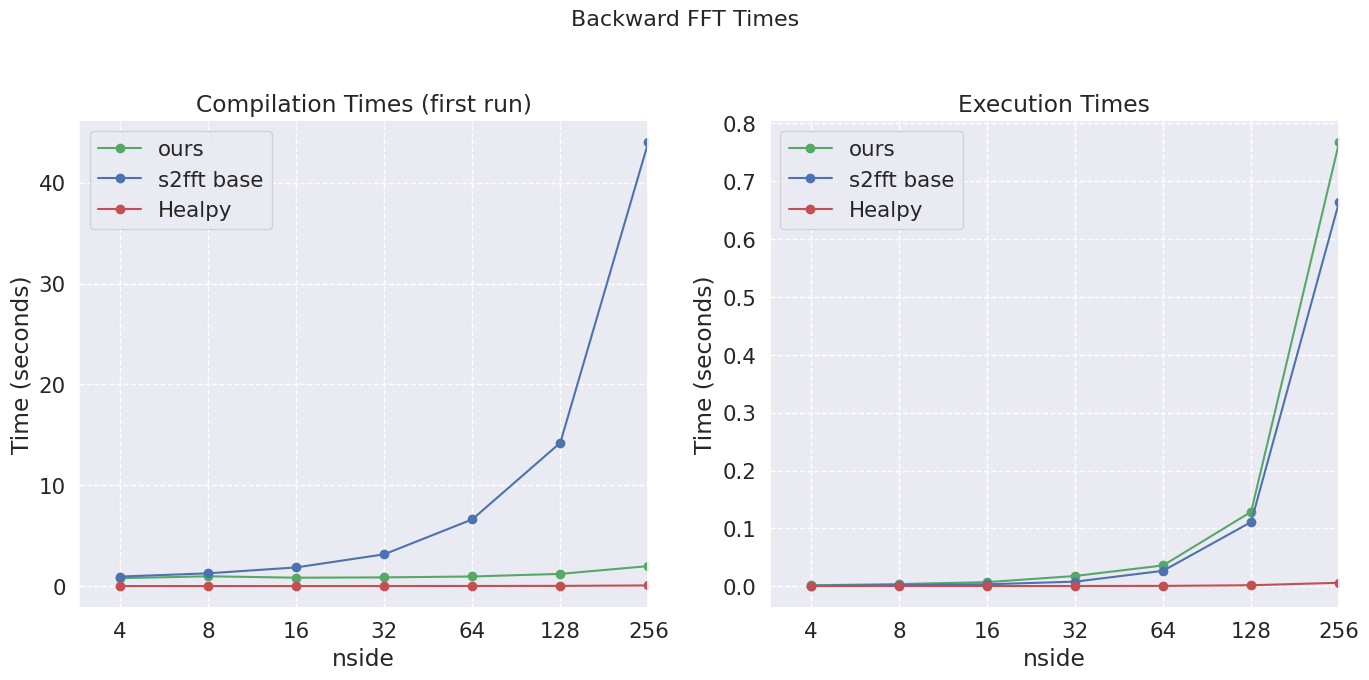

In [9]:
plot_times("Forward FFT Times", nsides, fwd_times)
plot_times("Backward FFT Times", nsides, bwd_times)